## Steam Game Review Analysis

In [1]:
from pyspark.sql import SparkSession, functions, types, Row
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import parquet

In [2]:
# pip install matplotlib
# pip install seaborn
# pip install scikit-learn

In [3]:
spark = SparkSession.builder.appName('Steam Games Analysis').getOrCreate()
sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/03 12:44:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
game_df = spark.read.parquet('cleaned_steam_games')

In [5]:
tags_df = game_df.withColumn("tag", functions.explode("tags"))

In [6]:
# number of games for each tag
count_per_tag = tags_df.groupby("tag").count()
count_per_tag.show(truncate=False)

Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=19506Kb max_used=19534Kb free=111565Kb
 bounds [0x00000001089d8000, 0x0000000109d08000, 0x00000001109d8000]
 total_blobs=8523 nmethods=7547 adapters=886
 compilation: disabled (not enough contiguous free space left)
+--------------------------------------------------------+-----+
|tag                                                     |count|
+--------------------------------------------------------+-----+
|Match 3                                                 |184  |
|- 69% of the 26 user reviews for this game are positive.|1    |
|Tennis                                                  |15   |
|Grayfax Software                                        |1    |
|DragonSnow                                              |1    |
|Difficult                                               |2040 |
|Strategy RPG                                            |113  |
|Runner                                                  |92   |
|Education                             

In [7]:
count_per_tag.orderBy("count", ascending=False).show(30)

+----------------+-----+
|             tag|count|
+----------------+-----+
|           Indie|23257|
|          Action|15841|
|       Adventure|13086|
|          Casual|12722|
|      Simulation| 9154|
|        Strategy| 8475|
|             RPG| 7223|
|    Singleplayer| 6636|
|    Early Access| 6074|
|Great Soundtrack| 3128|
|     Atmospheric| 3076|
|     Multiplayer| 2991|
|              2D| 2984|
|    Free to Play| 2844|
|          Puzzle| 2840|
|              VR| 2343|
|         Violent| 2297|
|      Story Rich| 2209|
|       Difficult| 2040|
|         Fantasy| 2033|
|            Gore| 1900|
|          Horror| 1825|
|          Sports| 1792|
|           Anime| 1776|
|           Funny| 1710|
|  Pixel Graphics| 1710|
|          Sci-fi| 1699|
|      Platformer| 1671|
|         Shooter| 1633|
|    First-Person| 1611|
+----------------+-----+
only showing top 30 rows



In [8]:
# obtain top 20 tags
top_20 = count_per_tag.where(count_per_tag["count"] >= 2033).orderBy("count", ascending=False)
top_20.count()

20

In [9]:
tags = [row["tag"] for row in top_20.collect()]
counts = [row["count"] for row in top_20.collect()]

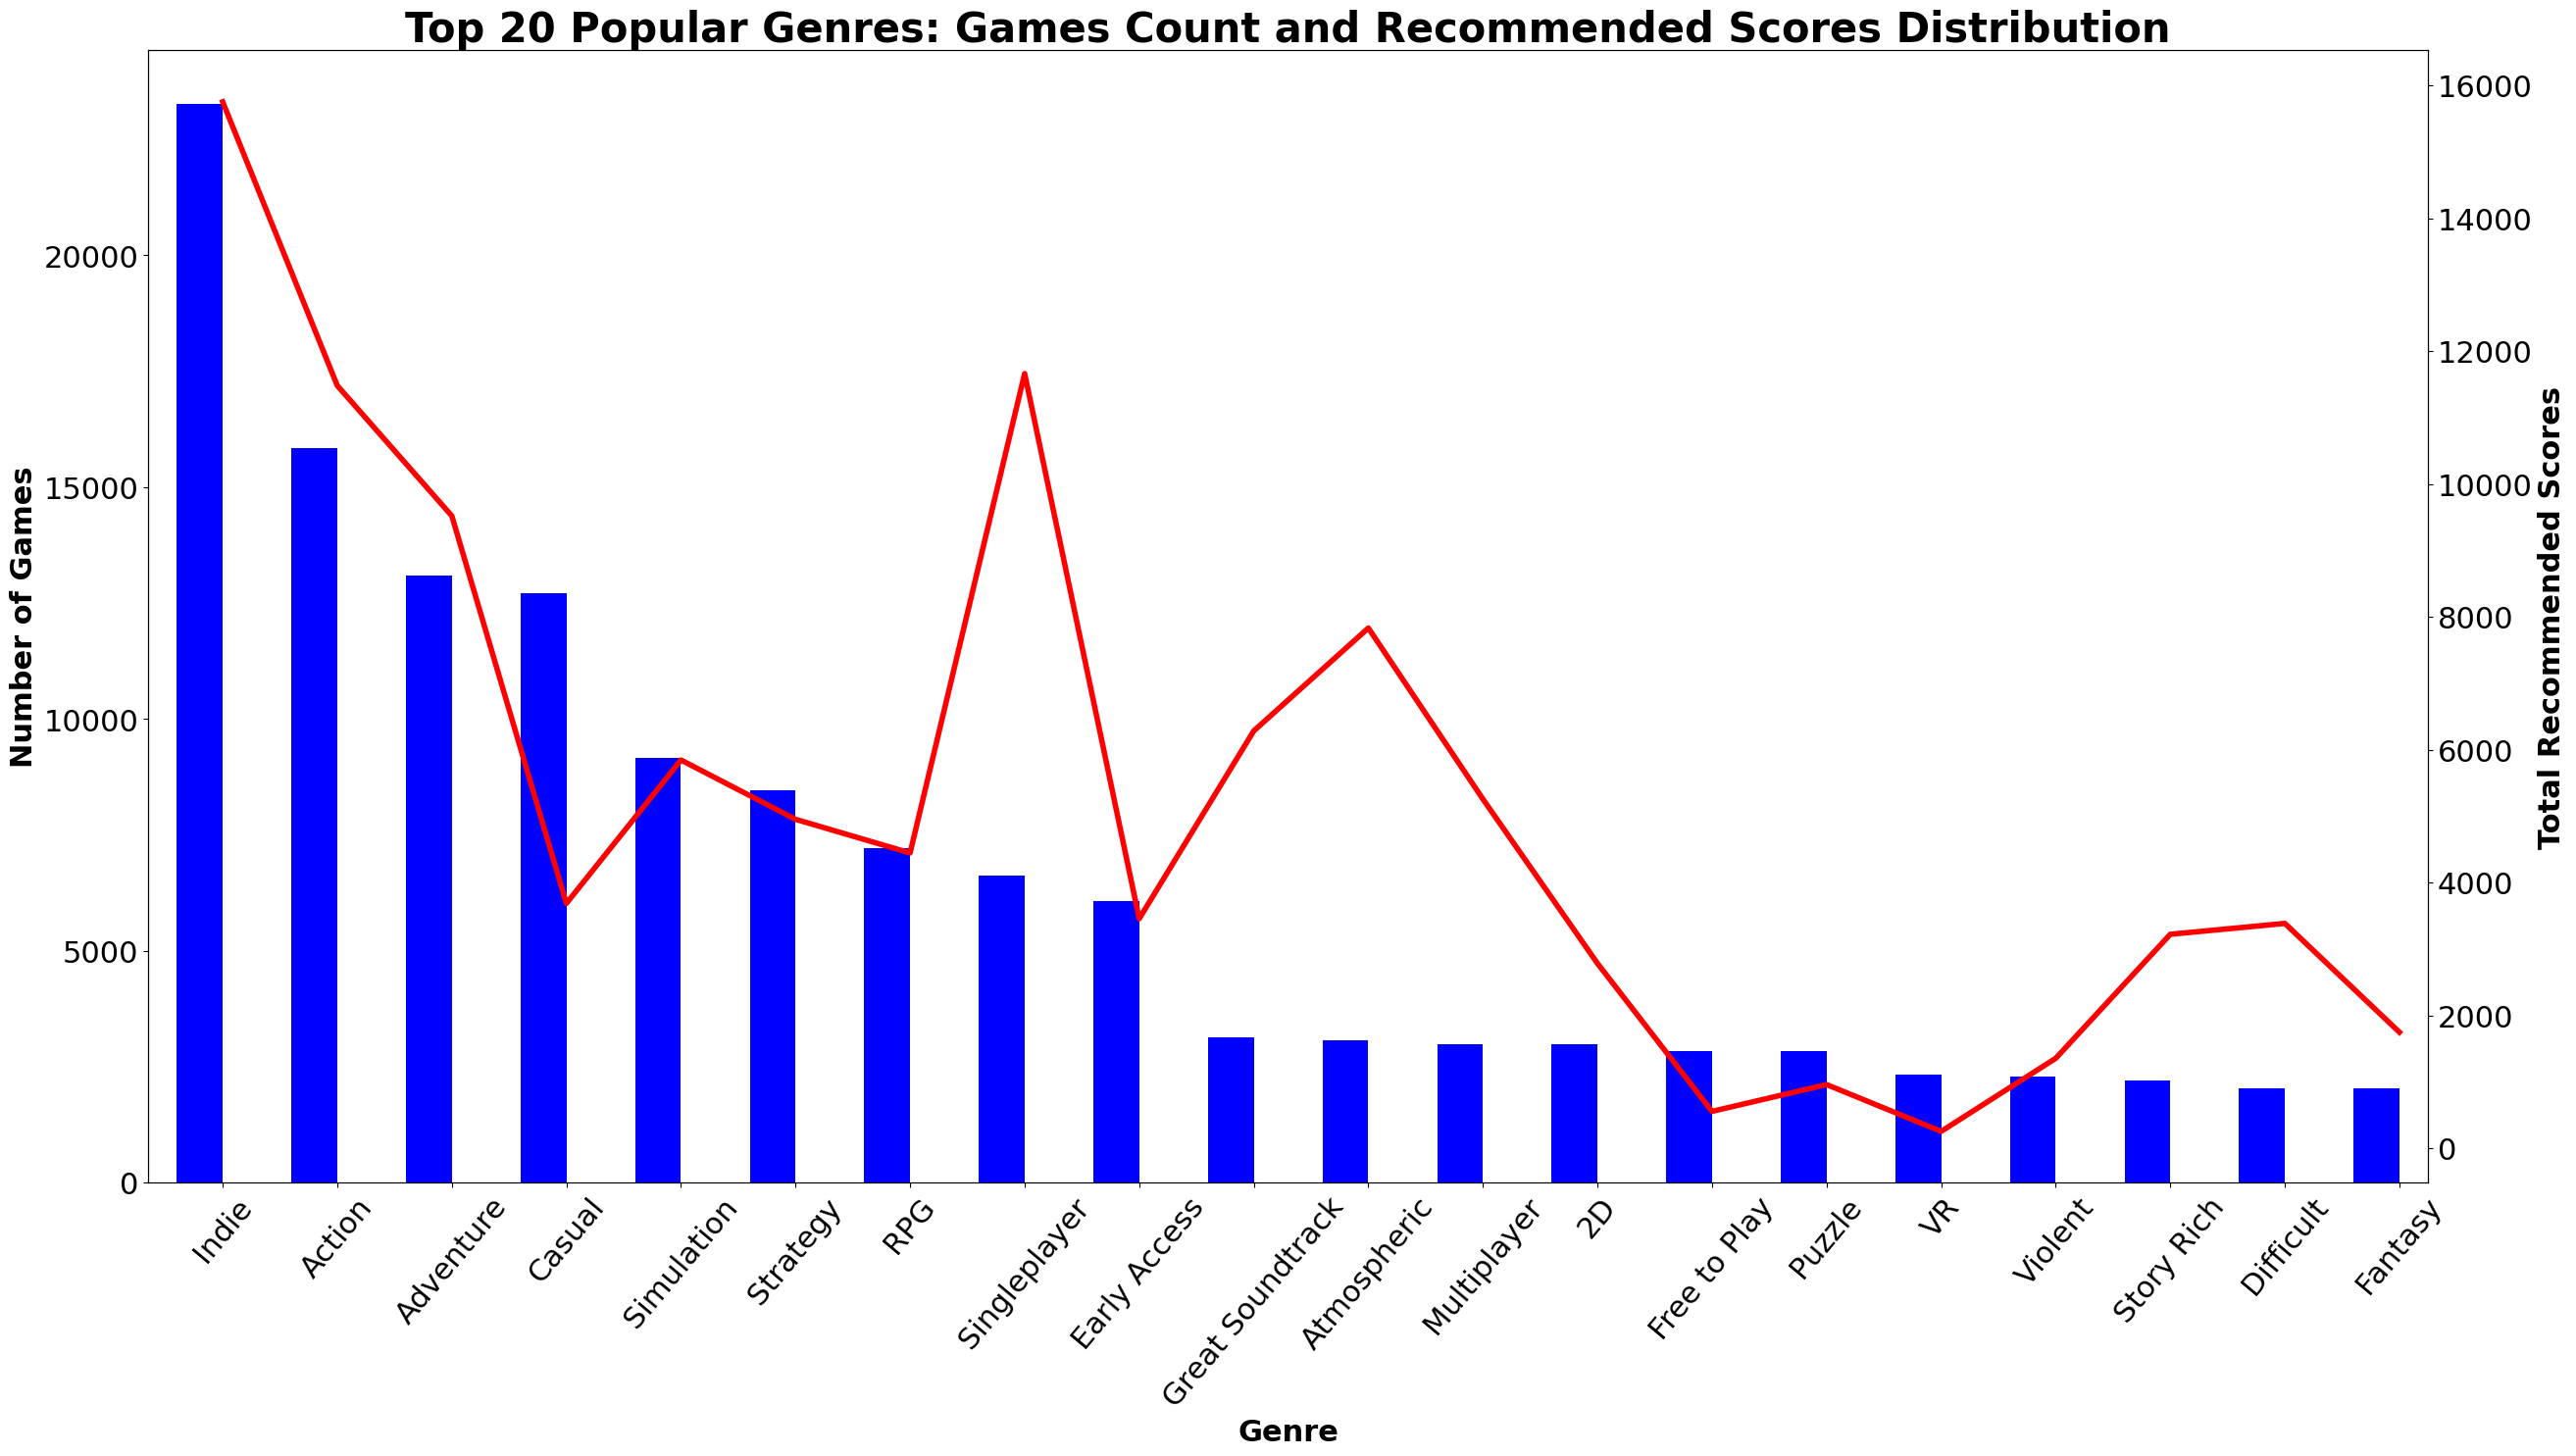

In [10]:
fig = plt.figure(figsize=(30, 15))
# plt.rcParams.update({'font.size': 22}) # must set in top
ax1 = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax1.twinx() # Create another axes that shares the same x-axis as ax.

# Customize the chart
plt.xlabel('Tag')
plt.ylabel('Count')
plt.title('Bar Chart of Game Tags by Count')

data = {'tags': ['Difficult', 'Adventure', 'VR', 'Atmospheric', 'Fantasy', 'Multiplayer', '2D', 'Violent', 'Story Rich', 'Singleplayer', 'Great Soundtrack', 'Puzzle', 'Early Access', 'Casual', 'Strategy', 'Action', 'Indie', 'Free to Play', 'RPG', 'Simulation'],
        'recommended': [3386698, 9519864, 257194, 7832112, 1748833, 5257550, 2784555, 1356898, 3223304, 11661784, 6284463, 961659, 3457825, 3688050, 4953679, 11481408, 15750653, 557902, 4447267, 5845971]}
df = pd.DataFrame(data)

order = ['Indie', 'Action', 'Adventure', 'Casual', 'Simulation', 'Strategy', 'RPG', 'Singleplayer',
         'Early Access', 'Great Soundtrack', 'Atmospheric', 'Multiplayer', '2D', 'Free to Play',
         'Puzzle', 'VR', 'Violent', 'Story Rich', 'Difficult', 'Fantasy']


sorterIndex = dict(zip(order, range(len(order))))
df['ordered_tag'] = df['tags'].map(sorterIndex)
df.sort_values(['ordered_tag'], ascending = [True], inplace = True)

#convert the Value column from min to hour
df['recommended'] = df['recommended']/1000

df['counts'] = counts
df = df.set_index('tags')

# plot charts
df.counts.plot(kind='bar', color='blue', ax=ax1, width=0.4, position=1)
df.recommended.plot(kind='line', color='red', ax=ax2, lw=4)

# Add labels
ax1.set_ylabel('Number of Games', fontsize=22, weight='bold')
ax2.set_ylabel('Total Recommended Scores', fontsize=22, weight='bold')
ax1.set_xlabel('Genre', fontsize=22, weight='bold')

# Increase the font size of x-axis and y-axis tick labels
ax1.tick_params(axis='x', labelsize=22)
ax1.tick_params(axis='y', labelsize=22)
ax2.tick_params(axis='y', labelsize=22)

ax1.set_xticklabels(df.index, rotation = 50)

# plt.title('Bar Chart of Number of Games and Recommended Scores by Genre', weight='bold', fontsize=30)
plt.title('Top 20 Popular Genres: Games Count and Recommended Scores Distribution', weight='bold', fontsize=30)

# Display the chart
plt.show()


In [11]:
tags_df.groupBy("tag").avg("positive_review_percent") \
    .orderBy("avg(positive_review_percent)", ascending=False).show()

+--------------------+----------------------------+
|                 tag|avg(positive_review_percent)|
+--------------------+----------------------------+
|            etherane|                       100.0|
|            marnamai|                       100.0|
|       Sekai Project|                       100.0|
|    Carpe Fulgur LLC|                       100.0|
|    Devolver Digital|                        98.0|
|       Asymmetric VR|                        97.5|
|               Valve|                        96.0|
|             marbenx|                        94.0|
|Steve ""Khad"" Gr...|                        93.0|
|        Feature Film|                        90.5|
|             Sokoban|           90.08333333333333|
|          THQ Nordic|                        90.0|
|         Documentary|           89.63333333333334|
|          Automation|                       89.25|
|           Emotional|           88.91891891891892|
|         Unforgiving|           88.85714285714286|
|           

In [12]:
tags_df.join(top_20, 'tag').groupBy("tag").avg("positive_review_percent") \
    .orderBy("avg(positive_review_percent)", ascending=False).show()

+----------------+----------------------------+
|             tag|avg(positive_review_percent)|
+----------------+----------------------------+
|Great Soundtrack|            82.3942269671807|
|              2D|           81.37910850968032|
|      Story Rich|           81.35023866348449|
|          Puzzle|           80.34917458729365|
|       Difficult|            80.2534059945504|
|    Singleplayer|           78.09282460136674|
|     Atmospheric|           77.63593683311993|
|         Fantasy|           77.28164556962025|
|           Indie|           75.74365130667651|
|              VR|           75.43007275666936|
|       Adventure|           75.25557780320366|
|          Casual|           75.19557472342021|
|             RPG|           74.77562246670527|
|          Action|            74.5326060004959|
|     Multiplayer|           73.97330282227307|
|         Violent|           73.09345047923323|
|        Strategy|           72.63069016152717|
|    Free to Play|           72.26820388

In [13]:
nonnull_overall_review = game_df.where(game_df["overall_review"].isNotNull()) \
    .where(game_df["overall_review"] != "")

In [14]:
nonnull_overall_review.groupBy("overall_review").count().orderBy("count", ascending=False).show(truncate=False)

+-----------------------+-----+
|overall_review         |count|
+-----------------------+-----+
|<10 reviews            |10890|
|Mixed                  |4576 |
|Very Positive          |4444 |
|Positive               |3479 |
|Mostly Positive        |3232 |
|Mostly Negative        |766  |
|Overwhelmingly Positive|309  |
|Negative               |132  |
|Very Negative          |34   |
|Overwhelmingly Negative|7    |
+-----------------------+-----+



Most games have not been reviewed by more than 10 people, hence no rating has been given yet

In [15]:
tags_df.describe(['overall_review', 'positive_review_percent', 'num_reviews']).show()

+-------+--------------+-----------------------+-----------------+
|summary|overall_review|positive_review_percent|      num_reviews|
+-------+--------------+-----------------------+-----------------+
|  count|        194551|                 148202|           148202|
|   mean|          null|      76.39109458711758|3284.858706360238|
| stddev|          null|      17.19248713636344|41521.96306320381|
|    min|              |                    0.0|               10|
|    max| Very Positive|                  100.0|          3094223|
+-------+--------------+-----------------------+-----------------+



In [16]:
tags_df_many_reviews = tags_df.where(tags_df["overall_review"]!="<10 reviews")

Average percentage of positive reviews per game tag is approximately 76.4%

In [17]:
avg_pos = tags_df_many_reviews.groupBy("tag").agg(functions.avg("positive_review_percent").alias("avg_prop_pos_review"))
top_neg = avg_pos.where(avg_pos["avg_prop_pos_review"].isNotNull()).orderBy("avg_prop_pos_review", ascending=True)

In [18]:
top_pos = avg_pos.where(avg_pos["avg_prop_pos_review"].isNotNull()).orderBy("avg_prop_pos_review", ascending=False)
top_pos.show(40)

+--------------------+-------------------+
|                 tag|avg_prop_pos_review|
+--------------------+-------------------+
|            etherane|              100.0|
|            marnamai|              100.0|
|       Sekai Project|              100.0|
|    Carpe Fulgur LLC|              100.0|
|    Devolver Digital|               98.0|
|       Asymmetric VR|               97.5|
|               Valve|               96.0|
|             marbenx|               94.0|
|Steve ""Khad"" Gr...|               93.0|
|        Feature Film|               90.5|
|             Sokoban|  90.08333333333333|
|          THQ Nordic|               90.0|
|         Documentary|  89.63333333333334|
|          Automation|              89.25|
|           Emotional|  88.91891891891892|
|         Unforgiving|  88.85714285714286|
|                 BMX|  87.66666666666667|
|                Cats|  87.27777777777777|
|            Spelling|              87.25|
|          Zai Studio|               87.0|
|      Touc

In [19]:
# List of least positive reviews genres
genres_list = ["Basketball","Cycling","360 Video","Pool","Gambling", "Offroad", \
    "MOBA", "Massively Multiplayer","Motocross","Bikes","MMORPG"
]

# Convert the list to a Spark DataFrame
schema = types.StringType()
least_pos_genres_list = spark.createDataFrame(genres_list, schema=schema).toDF("tag")

# Show the DataFrame
least_pos_genres_list.show()

+--------------------+
|                 tag|
+--------------------+
|          Basketball|
|             Cycling|
|           360 Video|
|                Pool|
|            Gambling|
|             Offroad|
|                MOBA|
|Massively Multipl...|
|           Motocross|
|               Bikes|
|              MMORPG|
+--------------------+



In [20]:
least_pos_genres_df = tags_df.where(tags_df["overall_review"]!="<10 reviews").join(least_pos_genres_list, 'tag', 'inner').groupBy("tag") \
    .agg(functions.collect_list("overall_review").alias("overall_reviews"))

tags2 = [row.tag for row in least_pos_genres_df.select("tag").collect()]
overall_reviews2 = [row.overall_reviews for row in least_pos_genres_df.select("overall_reviews").collect()]

In [21]:
# Flatten the list of overall reviews
neg_df = pd.DataFrame({'tag': tags2, 'overall_reviews': overall_reviews2}) \
    .explode('overall_reviews')

In [22]:
tagsrev_df = tags_df.join(top_20, 'tag', 'inner').groupBy("tag") \
    .agg(functions.collect_list("overall_review").alias("overall_reviews"))

In [23]:
tags1 = [row.tag for row in tagsrev_df.select("tag").collect()]
overall_reviews1 = [row.overall_reviews for row in tagsrev_df.select("overall_reviews").collect()]

In [24]:
tagrev_pddf = pd.DataFrame({'tag': tags1, 'overall_reviews': overall_reviews1})

In [25]:
# Flatten the list of overall reviews
tagrev_pddf = tagrev_pddf.explode('overall_reviews')

In [26]:
# order a Pandas DataFrame based on a customized order
custom_order = ['Indie', 'Action', 'Adventure', 'Casual', 'Simulation', 'Strategy', 'RPG',
 'Singleplayer', 'Early Access', 'Great Soundtrack', 'Atmospheric', 'Multiplayer', '2D',
 'Free to Play', 'Puzzle', 'VR', 'Violent', 'Story Rich', 'Difficult', 'Fantasy']
 
tagrev_pddf['tag'] = pd.Categorical(tagrev_pddf['tag'], categories=custom_order, ordered=True)
tagrev_pddf = tagrev_pddf.sort_values(by='tag')
tagrev_pddf

,tag,overall_reviews
16,Indie,Mixed
16,Indie,Very Positive
16,Indie,Very Positive
16,Indie,Very Positive
16,Indie,Positive
...,...,...
4,Fantasy,<10 reviews
4,Fantasy,Mostly Positive
4,Fantasy,Mixed
4,Fantasy,<10 reviews


In [27]:
# Overall Average positive review 
avg_prop_positive_reviews = tags_df.select((functions.avg(tags_df["positive_review_percent"])).alias("avg_num_positive_reviews")) \
    .collect()[0]["avg_num_positive_reviews"] / 100

In [28]:
# Define the categorical order for 'overall_reviews'
overall_review_order = ["Overwhelmingly Positive", 'Mostly Positive', 'Very Positive',
                        'Positive', 'Mixed', 'Negative', 'Very Negative',
                        'Mostly Negative', 'Overwhelmingly Negative', '<10 reviews']

custom_colors = ['#001F3F',  # Dark Blue
    '#003366',          # Slightly lighter blue
    '#0056b3',          # Lighter blue
    '#007BFF',          # Blue
    '#b783d5',          # Mixed
    '#ff6666',          # Negative
    '#ff3333',          # Very Negative
    '#cc0000',          # Mostly negative
    '#971717',          # Overwhelmingly negative
    'grey',             # <10 reviews
    '#6d8f44'           # nan
]


In [29]:
def plot_stacked_bar(dataframe):
    df = dataframe.groupby('tag')['overall_reviews'].value_counts(normalize=True, dropna=True)
    # df = df.groupby('tag').transform(lambda x: x/sum(x))

    df = df.unstack()

    df.columns = pd.CategoricalIndex(df.columns.values, 
                                    ordered=True, 
                                    categories=overall_review_order)
    df = df.sort_index(axis=1)

    # Create a stacked bar plot
    ax = df.plot.bar(stacked=True, rot=90, color=custom_colors)

    # Create a horizontal line
    ax.axhline(y=float(avg_prop_positive_reviews), color='red', linestyle='--', label='Avg. Positive Reviews')

    # order the plot in a descending order of 
    # Customize the plot
    ax.set_xlabel('Genres')
    ax.set_ylabel('Proportion of Reviews')
    ax.set_title('Overall Reviews by Genres')
    ax.legend(title='Overall Review', bbox_to_anchor=(1, 1), loc='upper left')

    # Show the plot
    plt.show()


/var/folders/8n/4krln465113bpt4x1bnwnwr80000gn/T/ipykernel_89662/1692701301.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = dataframe.groupby('tag')['overall_reviews'].value_counts(normalize=True, dropna=True)


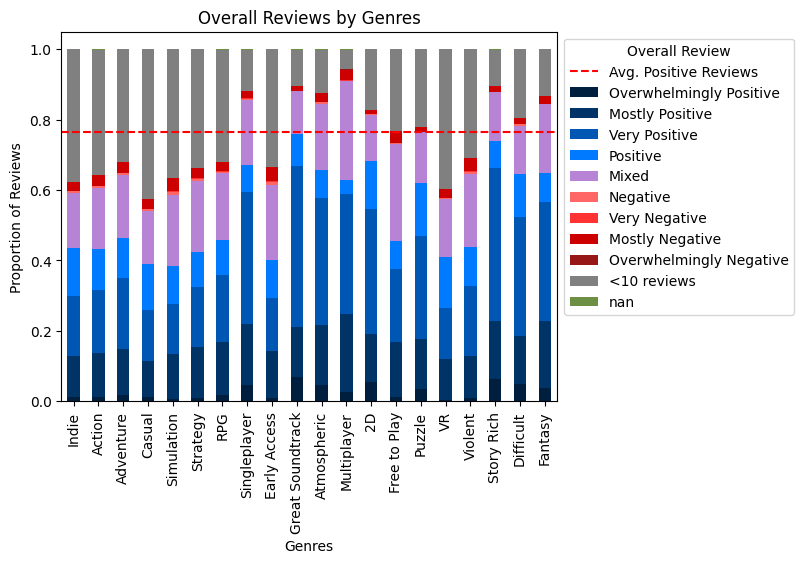

In [30]:
plot_stacked_bar(tagrev_pddf)

In [31]:
custom_colors = ['#001F3F',  # Dark Blue
    '#003366',          # Slightly lighter blue
    '#0056b3',          # Lighter blue
    '#007BFF',          # Blue
    '#b783d5',          # Mixed
    '#ff6666',          # Negative
    '#ff3333',          # Very Negative
    '#cc0000',          # Mostly negative
    'grey',             # Overwhelmingly negative         
]

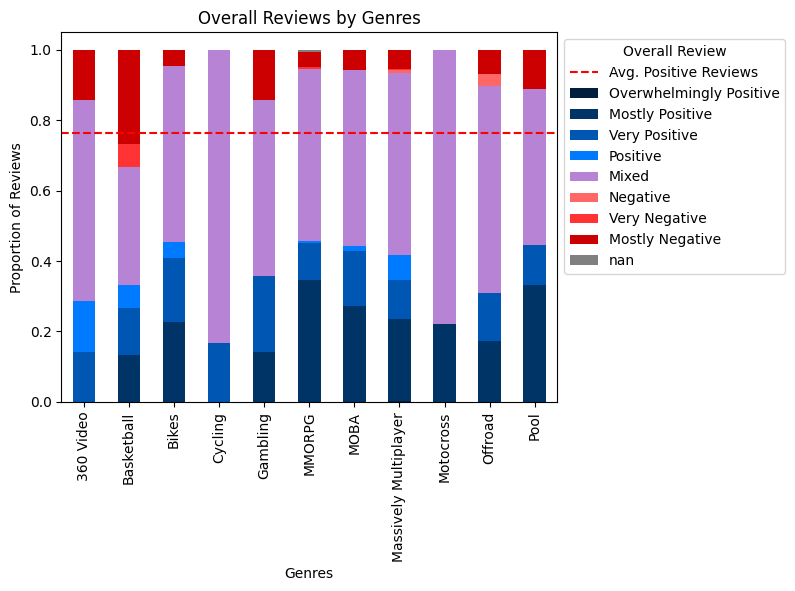

In [32]:
plot_stacked_bar(neg_df)

In [33]:
# tags with highest average positive review percentage
most_pos_genres_list = ["Asymmetric VR", "Documentary", "Automation", "Emotional",
               "Touch-Friendly", "Programming", "Time Travel", "Score Attack", 
               "Cute", "Romance", "Word Game", "Drama", "Cats",
               "Puzzle"]

# Convert the list to a Spark DataFrame
schema = types.StringType()
most_pos_genres_list = spark.createDataFrame(most_pos_genres_list, schema=schema).toDF("tag")

# Show the DataFrame
most_pos_genres_list.show() 

+--------------+
|           tag|
+--------------+
| Asymmetric VR|
|   Documentary|
|    Automation|
|     Emotional|
|Touch-Friendly|
|   Programming|
|   Time Travel|
|  Score Attack|
|          Cute|
|       Romance|
|     Word Game|
|         Drama|
|          Cats|
|        Puzzle|
+--------------+



In [34]:
most_pos_genres_df = tags_df.where(tags_df["overall_review"]!="<10 reviews").join(most_pos_genres_list, 'tag', 'inner').groupBy("tag") \
    .agg(functions.collect_list("overall_review").alias("overall_reviews"))

tags_pos = [row.tag for row in most_pos_genres_df.select("tag").collect()]
overall_reviews_pos = [row.overall_reviews for row in most_pos_genres_df.select("overall_reviews").collect()]

# Flatten the list of overall reviews
pos_df = pd.DataFrame({'tag': tags_pos, 'overall_reviews': overall_reviews_pos}) \
    .explode('overall_reviews')

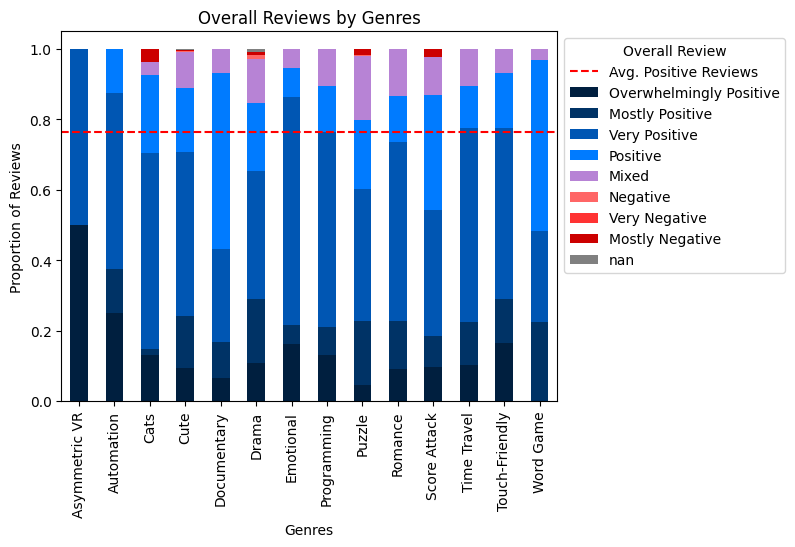

In [35]:
plot_stacked_bar(pos_df)

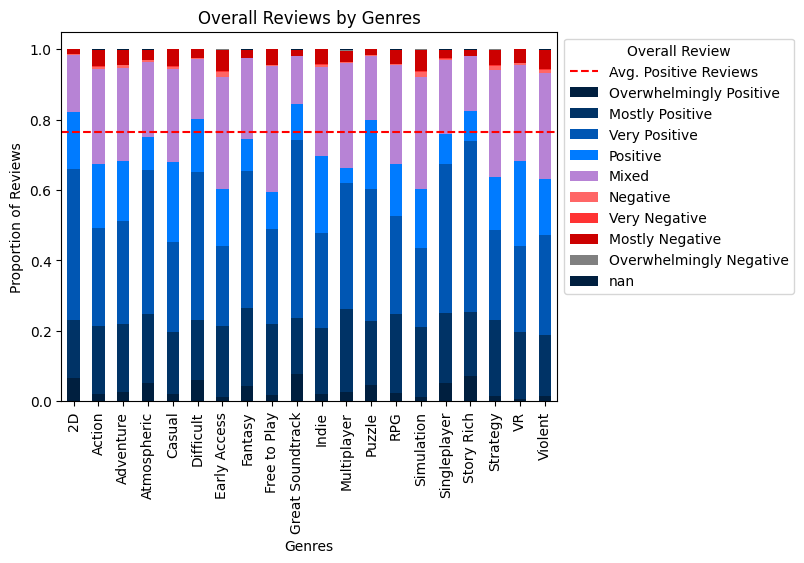

In [36]:
tagsrev_df2 = tags_df.where(tags_df["overall_review"]!="<10 reviews").join(top_20, 'tag', 'inner').groupBy("tag") \
    .agg(functions.collect_list("overall_review").alias("overall_reviews"))

tags2 = [row.tag for row in tagsrev_df2.select("tag").collect()]
overall_reviews2 = [row.overall_reviews for row in tagsrev_df2.select("overall_reviews").collect()]

tagrev_pddf2 = pd.DataFrame({'tag': tags2, 'overall_reviews': overall_reviews2}).explode('overall_reviews')

plot_stacked_bar(tagrev_pddf2)

All top 20 most popular tags lie above the average number of positive reviews

## Steam Games Recommendation System

In [37]:
df_recommend = pd.read_parquet('cleaned_steam_games', engine='pyarrow')

In [38]:
# Open the file in binary read mode ('rb')
with open('cosine_sim.pkl', 'rb') as file:
    # Load the contents of the file into a variable (e.g., cosine_sim_loaded)
    cosine_sim_loaded = pickle.load(file)

In [39]:
def get_index_from(title):
    return df_rec[df_rec.name == title].index.values[0]

def get_title_from_index(index):
    return df_rec[df_rec.index == index]["name"].values[0]

In [40]:
# returns name and index of the game
# game_id: int
def steam_game_recommender(game_id, cosine_sim, dataframe):
    # features = ['desc_snippet', 'popular_tags', 'developers']
    # dataframe = dataframe.dropna
    game_index = dataframe[dataframe.game_id == game_id].index.values[0]

    # generate similar games matrix
    similar_games = list(enumerate(cosine_sim[game_index]))

    # Sorting the similar games in descending order
    sorted_similar_games = sorted(similar_games, key = lambda x:x[1], reverse = True)

    i=0
    recommended_games = []
    for games in sorted_similar_games:
        if i != 0:
            recommended_games.append(dataframe[dataframe.index == games[0]]["name"].values[0])
        i = i+1
        if i>5:
            break
    
    return recommended_games

In [42]:
# Cast the df_recommend.game_id to int
df_recommend.game_id = df_recommend.game_id.astype(int)

In [43]:
recommended_games = steam_game_recommender(218620, cosine_sim_loaded, df_recommend)
recommended_games

['Blazing Beaks',
 'South Park™: The Fractured But Whole™ - Season Pass',
 'Peas Adventure',
 'Two Point Hospital: Pebberley Island',
 'Panzer Tactics HD']

In [ ]:
# return a dictinary of game_id and name
# game_id: int
def steam_game_recommender(game_id, cosine_sim, dataframe):
    game_index = dataframe[dataframe.game_id == game_id].index.values[0]

    # generate similar games matrix
    similar_games = list(enumerate(cosine_sim[game_index]))

    # Sorting the similar games in descending order
    sorted_similar_games = sorted(similar_games, key = lambda x:x[1], reverse = True)

    i=0
    recommended_games = []
    for games in sorted_similar_games:
        if i != 0:
            recommended_games.append(dataframe[dataframe.index == games[0]]["name"].values[0])
        i = i+1
        if i>5:
            break
    
    return recommended_games

In [ ]:
recommended_games = steam_game_recommender(218620, cosine_sim_loaded, df_recommend)
recommended_games

In [ ]:
# read game_ids.txt into a column in a dataframe
game_ids = pd.read_csv("game_ids.txt", sep=",", header=None)

# covert to rows
game_ids = game_ids.transpose()

In [ ]:
# return only matching game_ids in the dataframe with df_recommend game_id
matching_games = df_recommend
matching_games = matching_games[matching_games.game_id.isin(game_ids[0])]

# convert the index of matching_games in default index
matching_games = matching_games.reset_index(drop=True)

In [ ]:
steam_game_recommender(218620, cosine_sim_loaded, matching_games)

In [ ]:
# df_recommend[df_recommend["name"].str.contains("ARK")]

In [ ]:
# convert matching_games to list
items = str(matching_games.tolist())

# write mactching_games to a file
file = open('matching_games.txt','w')
file.writelines(items)
file.close()

In [ ]:
def load_cosine_sim():
    # Open the file in binary read mode ('rb')
    with open('cosine_sim.pkl', 'rb') as file:
        # Load the contents of the file into a variable (e.g., cosine_sim_loaded)
        cosine_sim_loaded = pickle.load(file)
    return cosine_sim_loaded

def load_df_recommend():
    df_recommend = pd.read_parquet('cleaned_steam_games', engine='pyarrow')
    return df_recommend